# Bart Analysis

Analysis of the open bart dataset

## TODO

* [ ] Sundays versus Weekday + Saturday
* [ ] Fare analysis
  * [ ] revenue @ clipper price
  * [ ] revenue @ fixed rate
* [ ] distance between stations (number of stops, miles)
* [ ] analyze commuter versus non-commuter rides by splitting into M-F 7am-6pm & other

In [117]:
import pandas as pd
import time
import altair as alt
import requests
import itertools

alt.renderers.enable("notebook")

RendererRegistry.enable('notebook')

In [13]:
df = pd.concat(
    [
#         pd.read_csv(
#             "http://64.111.127.166/origin-destination/date-hour-soo-dest-2017.csv.gz",
#             header=None,
#         ),
#         pd.read_csv(
#             "http://64.111.127.166/origin-destination/date-hour-soo-dest-2018.csv.gz",
#             header=None,
#         ),
        pd.read_csv(
            "http://64.111.127.166/origin-destination/date-hour-soo-dest-2019.csv.gz",
            header=None,
        ),
    ]
)

In [14]:
df.shape

(8865720, 5)

In [15]:
df.columns = ["date", "hour", "start", "stop", "riders"]
df.head()

,date,hour,start,stop,riders
0,2019-01-01,0,12TH,12TH,3
1,2019-01-01,0,12TH,16TH,4
2,2019-01-01,0,12TH,ANTC,1
3,2019-01-01,0,12TH,BAYF,1
4,2019-01-01,0,12TH,CIVC,2


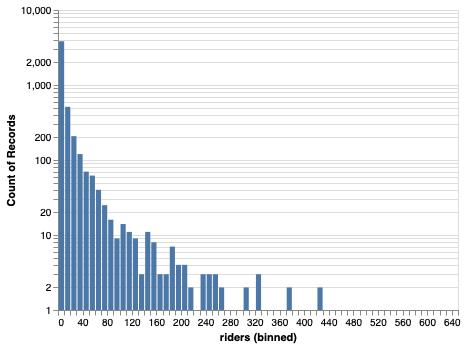

In [16]:
alt.Chart(df.sample(5000)).mark_bar().encode(
    x=alt.X("riders", bin=alt.Bin(maxbins=100)),
    y=alt.Y("count()", scale=alt.Scale(type="log")),
)

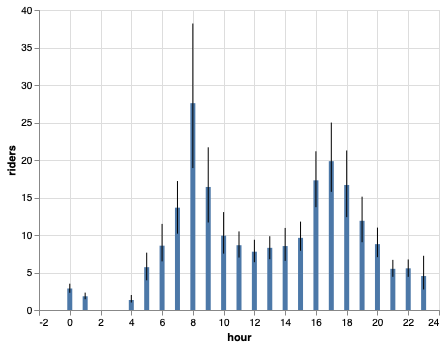

In [55]:
# TODO: this chart is highly sensitive to down-sampling. Probably due to days where special events were being held
# causing the 2am bar to change
bars = alt.Chart().mark_bar().encode(x="hour", y="mean(riders)")

error_bars = alt.Chart().mark_errorbar(extent="ci").encode(x="hour", y="riders")

alt.layer(bars, error_bars, data=df.sample(5000))

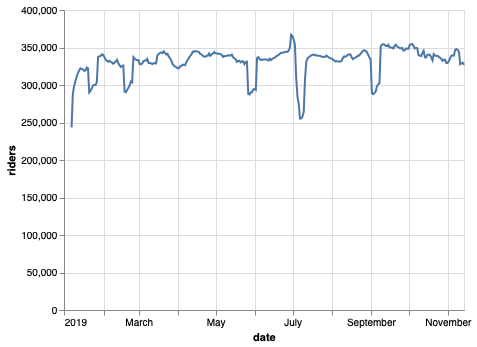

In [76]:
ser = pd.DataFrame(
    pd.Series(df.groupby("date").apply(lambda x: x.riders.sum()))
    .rolling(window=7)
    .mean()
).reset_index()
ser.columns = ["date", "riders"]

alt.Chart(ser).mark_line().encode(x="date:T", y="riders")

In [77]:
totaled = pd.DataFrame(
    df.groupby(["start", "stop"]).apply(lambda x: sum(x.riders))
).reset_index()
totaled.columns = ["start", "stop", "rides"]

In [78]:
totaled.head()

,start,stop,rides
0,12TH,12TH,16656
1,12TH,16TH,86846
2,12TH,19TH,16669
3,12TH,24TH,72346
4,12TH,ANTC,42513


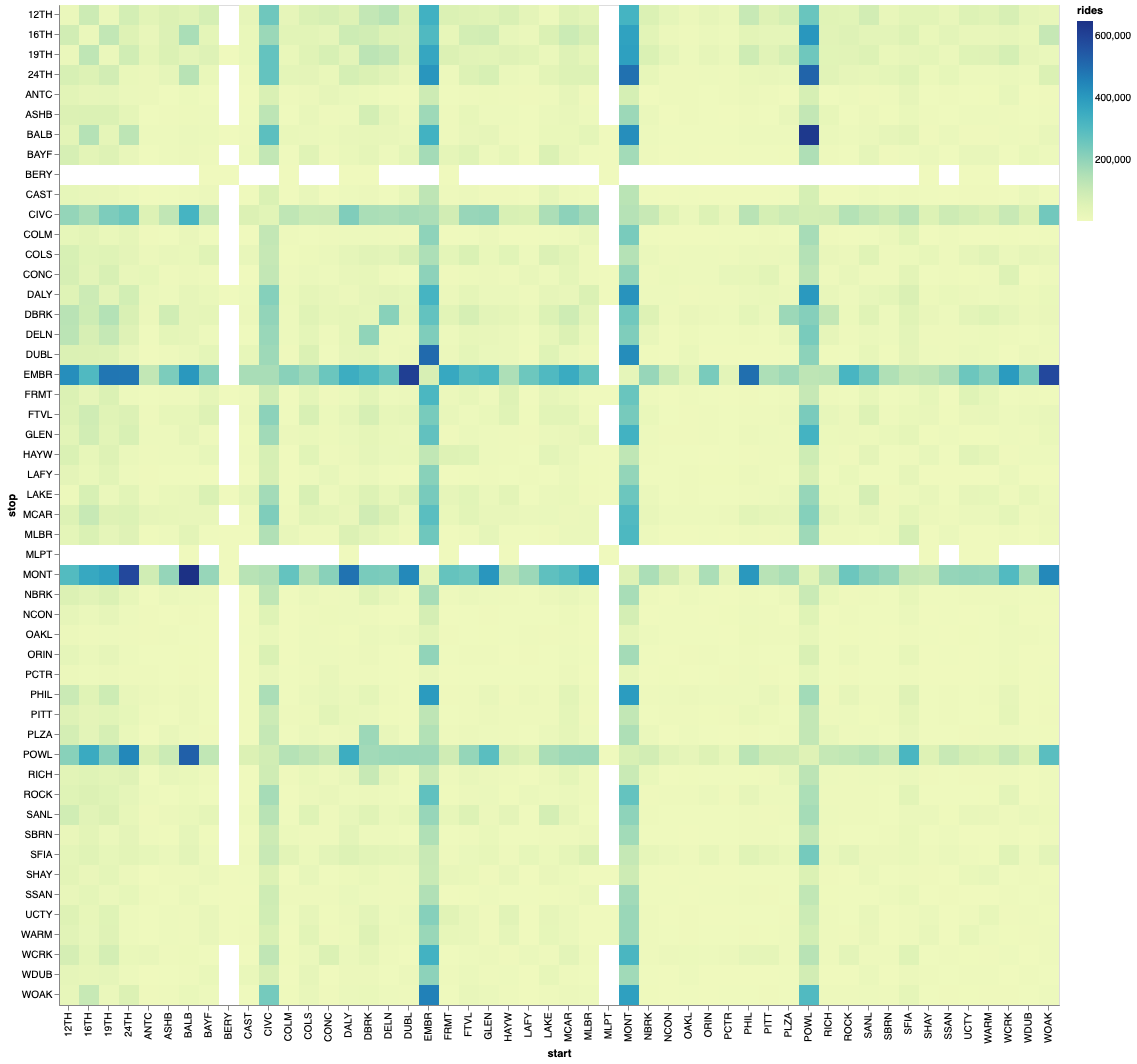

In [83]:
alt.Chart(totaled).mark_rect().encode(
    x="start:O",
    y="stop:O",
    color=alt.Color("rides"),
    tooltip=["start", "stop", "rides"],
)

# Fare Analysis

In [121]:
def get_fare(origin, destination):
    """
    Fetch fare information from the official BART API (http://api.bart.gov/docs/overview/examples.aspx)
    """
    r = requests.get(
        f"http://api.bart.gov/api/sched.aspx?cmd=fare&orig={origin}&dest={destination}&key=MW9S-E7SL-26DU-VV8V&json=y"
    )
    try:
        dat = r.json()
    except json.decoder.JSONDecodeError:
        return None
    else:
        return float(dat['root']['trip']['discount']['clipper'])

In [122]:
get_fare('24TH', 'DUBL')

2.4

In [123]:
bart_fares = pd.DataFrame(
    [
        {
            "start": origin,
            "stop": destination,
            "fare": get_fare(origin, destination),
        }
        for origin, destination in list(itertools.product(stations, stations))
    ]
)

In [126]:
bart_fares.head()

,origin,destination,fare
0,PLZA,PLZA,2.20
1,PLZA,PHIL,1.50
2,PLZA,DELN,0.75
3,PLZA,NBRK,0.75
4,PLZA,PITT,1.90


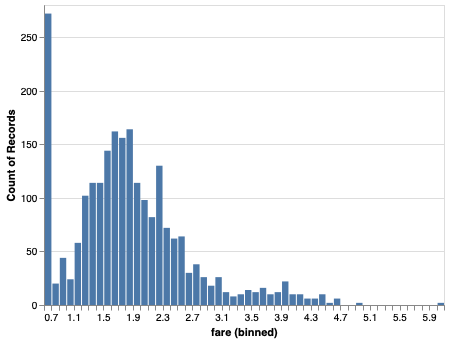

In [130]:
alt.Chart(
    bart_fares
).mark_bar().encode(
    x=alt.X('fare', bin=alt.Bin(maxbins=100)),
    y='count()'
)

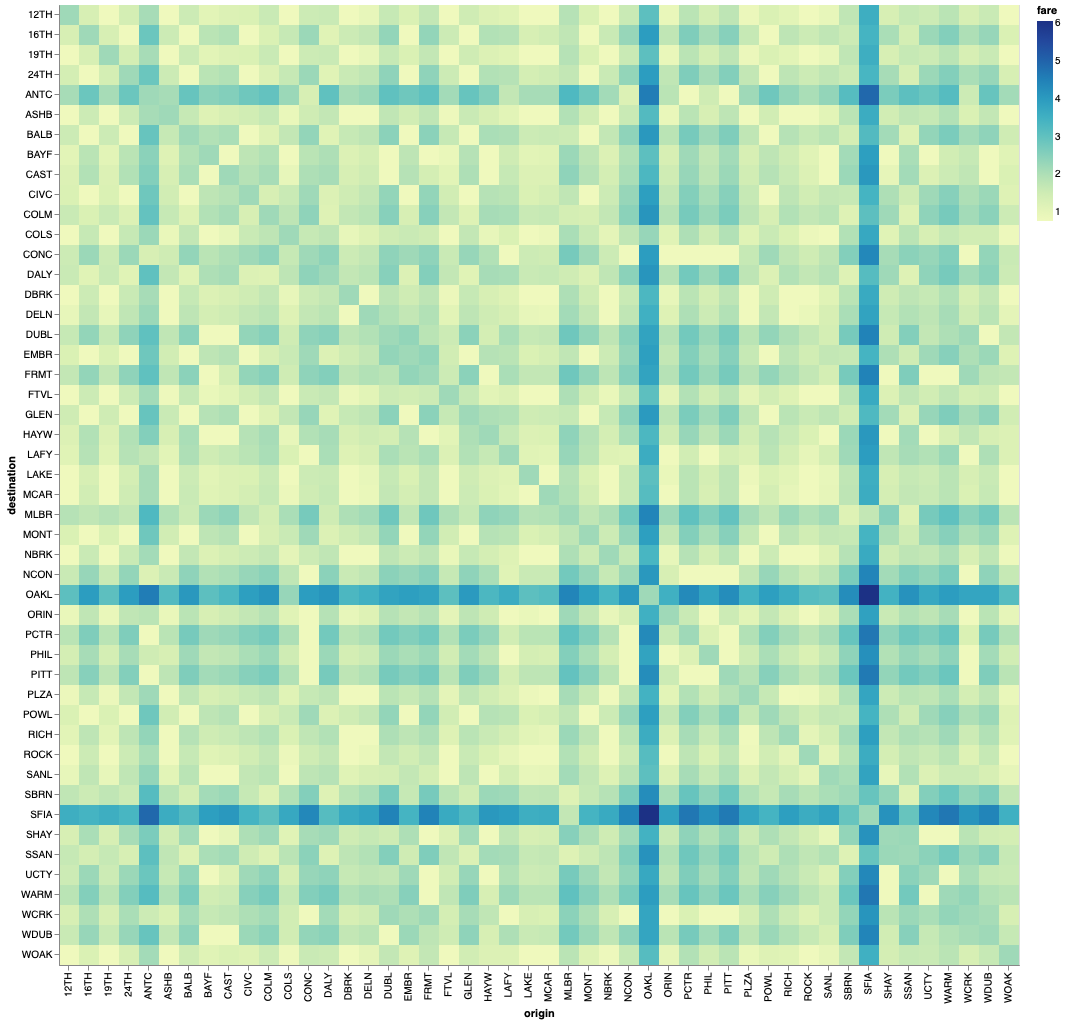

In [137]:
alt.Chart(bart_fares).mark_rect().encode(
    x="origin:O",
    y="destination:O",
    color=alt.Color("fare"),
    tooltip=["origin", "destination", "fare"],
)

In [168]:
bart_fares_rides = bart_fares.merge(totaled, on=["start", "stop"])
bart_fares_rides["revenue"] = bart_fares_rides["fare"] * bart_fares_rides["rides"]
bart_fares_rides.head()

,start,stop,fare,rides,revenue
0,PLZA,PLZA,2.20,4912,10806.4
1,PLZA,PHIL,1.50,4750,7125.0
2,PLZA,DELN,0.75,22078,16558.5
3,PLZA,NBRK,0.75,14128,10596.0
4,PLZA,PITT,1.90,1866,3545.4


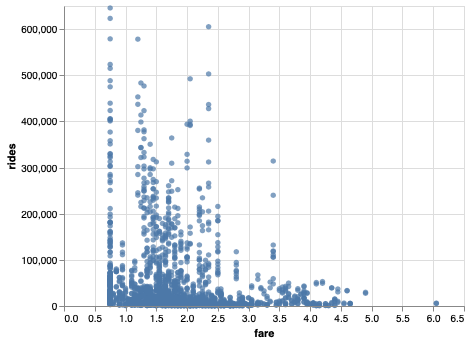

In [169]:
alt.Chart(bart_fares_rides).mark_circle().encode(
    x="fare", y="rides", tooltip=["start", "stop", "fare", "rides"],
)

In [179]:
df_revenue = df.merge(bart_fares, on=['start', 'stop'])
df_revenue['revenue'] = df_revenue['riders'] * df_revenue['fare']
df_revenue.head()

,date,hour,start,stop,riders,fare,revenue
0,2019-01-01,0,12TH,12TH,3,2.2,6.6
1,2019-01-01,1,12TH,12TH,1,2.2,2.2
2,2019-01-01,10,12TH,12TH,1,2.2,2.2
3,2019-01-01,11,12TH,12TH,1,2.2,2.2
4,2019-01-01,12,12TH,12TH,2,2.2,4.4


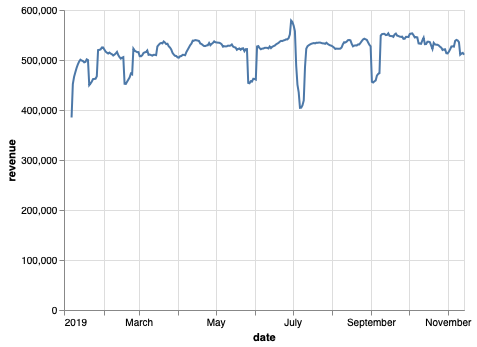

In [181]:
ser = pd.DataFrame(
    pd.Series(df_revenue.groupby("date").apply(lambda x: x.revenue.sum()))
    .rolling(window=7)
    .mean()
).reset_index()
ser.columns = ["date", "revenue"]

alt.Chart(ser).mark_line().encode(x="date:T", y="revenue")

In [186]:
df_revenue["revenue"].sum()  # does this match up with any public data ??

164738596.69999996

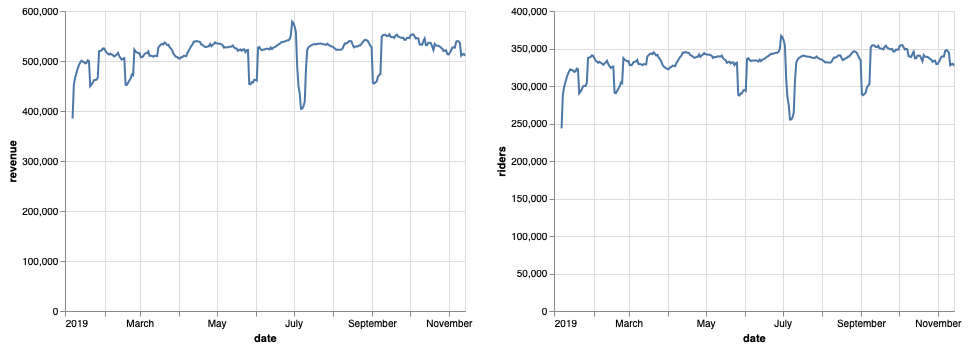

In [203]:
ser_revenue = pd.DataFrame(
    pd.Series(df_revenue.groupby("date").apply(lambda x: x.revenue.sum()))
    .rolling(window=7)
    .mean()
).reset_index()
ser_revenue.columns = ["date", "revenue"]

c1 = alt.Chart(ser_revenue).mark_line().encode(x="date:T", y="revenue")

ser_riders = pd.DataFrame(
    pd.Series(df_revenue.groupby("date").apply(lambda x: x.riders.sum()))
    .rolling(window=7)
    .mean()
).reset_index()
ser_riders.columns = ["date", "riders"]

c2 = alt.Chart(ser_riders).mark_line().encode(x="date:T", y="riders")

c1 | c2

In [205]:
# what would the flat rate be?
df_revenue['revenue'].sum() / df_revenue['riders'].sum()

1.564589977582788

In [206]:
df_revenue

,date,hour,start,stop,riders,fare,revenue
0,2019-01-01,0,12TH,12TH,3,2.2,6.6
1,2019-01-01,1,12TH,12TH,1,2.2,2.2
2,2019-01-01,10,12TH,12TH,1,2.2,2.2
3,2019-01-01,11,12TH,12TH,1,2.2,2.2
4,2019-01-01,12,12TH,12TH,2,2.2,4.4
...,...,...,...,...,...,...,...
8865715,2019-09-25,16,MLPT,BAYF,1,NaN,NaN
8865716,2019-10-08,7,BERY,19TH,1,NaN,NaN
8865717,2019-10-23,8,MLPT,POWL,1,NaN,NaN
8865718,2019-11-04,6,BERY,MONT,1,NaN,NaN
